
---

### Homework #2 

**Names:**

- Erica Drummond
- Madison Meyers
- Jake Miller
- Shrinath Parikh
- Pranati Yadlapalli  

*NEUR 3002 - Due 1/26/2024*

---

#### Question 1

##### **Leaky Integrate and Fire Code Explanation**

The code sets parameters such as the resting potential and threshold potential as well as a refractory period between spikes. Then it runs a simulation over 100 ms with a constant 100 $\mu A$ current. This resulted in steady firing of the LIF neuron as seen the generated plot. The plot also draws the spikes as thin "event" lines once the potential reaches threshold.


---

#### Questions 2 and 3
##### **Leaky Integrate and Fire Code**

*From ChatGPT with modifications*

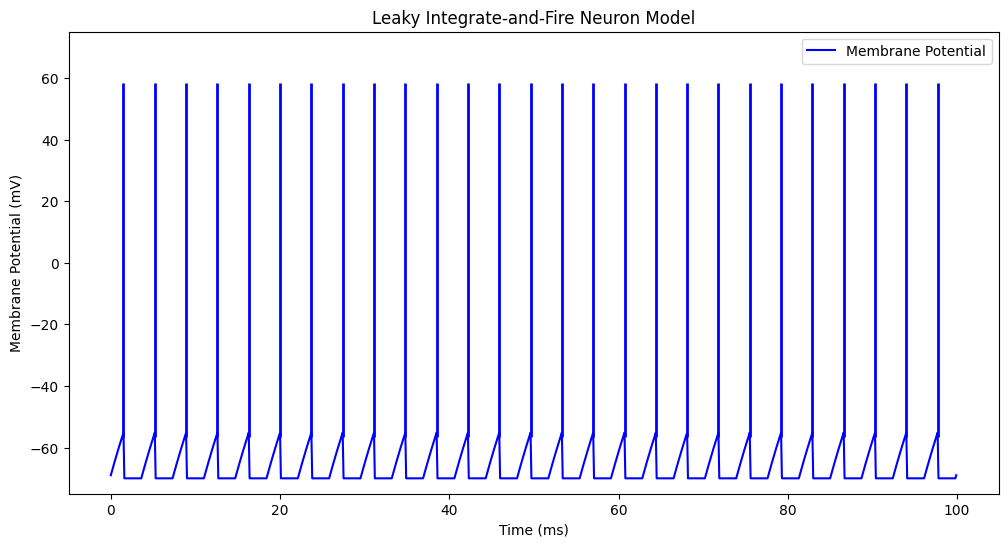

In [40]:
import numpy as np
import matplotlib.pyplot as plt

class LIFNeuron:
    def __init__(self, tau_m=10, v_rest=-70, v_thresh=-55, tau_ref=2):
        self.tau_m = tau_m  # membrane time constant
        self.v_rest = v_rest  # resting membrane potential
        self.v_thresh = v_thresh  # threshold potential
        self.tau_ref = tau_ref  # refractory period
        self.reset()

    def reset(self):
        self.v = self.v_rest
        self.refractory_time = 0

    def update(self, dt, current):
        if self.refractory_time > 0:
            self.refractory_time -= dt
            self.v = self.v_rest
        else:
            dv = (-(self.v - self.v_rest) + current) / self.tau_m * dt
            self.v += dv
            if self.v >= self.v_thresh:
                self.v = self.v_rest
                self.refractory_time = self.tau_ref
                return True  # Spike occurred
        return False

def simulate_lif_neuron(neuron, currents, dt=0.1, duration=100):
    
    num_steps = int(duration / dt)

    voltages = []
    spike_times = []

    for i in range(num_steps):
        current = currents[i] if i < len(currents) else 0
        spike_occurred = neuron.update(dt, current)
        voltages.append(neuron.v)

        if spike_occurred:
            spike_times.append(i * dt)

    time = np.arange(0, duration, dt)
    return time, voltages, spike_times

# Example usage:
currents = np.ones(1000)*100  # 100 ms of input current
neuron = LIFNeuron()
time, voltages, spike_times = simulate_lif_neuron(neuron, currents)

# Plotting the results
plt.figure(figsize=(12, 6))

plt.plot(time, voltages, label='Membrane Potential',color='b')
plt.eventplot(np.array(spike_times)-0.1, color='b', linewidths=2, linelengths=115) # Draw the spikes

plt.title('Leaky Integrate-and-Fire Neuron Model')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.ylim([-75, 75])
plt.legend()

plt.show()



---

#### Question 4

The LIF model does not do great at mimicking actual action potentials. The spike's are modeled as single time step ticks rather than having a depolarization and repolarization phase. Also, this model just inputs one generic current rather than taking into account many complex temporally or spatially summed inputs from presynaptic neurons. Biological neurons have other properties like plasticity which require more sophisticated models than the LIF to replicate. It only considers sodium and potassium channels as well when many other ions can play an important role in the spiking like calcium for instance. More complex modelling of the leak instead of a single resistor could also have an impact on variables like the time constant, effeting the firing.


---

#### Question 5

The most challenging aspect of this homework was producing a good model of an LIF neuron, especially when primarily using ChatGPT to generate the code. Getting more specific features or values directly out of ChatGPT was difficult, so there was extra work involved in parsing its code to modify it and improve our model. Essentially, it was easy to get a decent start from ChatGPT, but the real labor was in dissecting its code for improvements.


---
#### Question 6

This homework took 1.5 hours to complete.

---

### Homework #3 

**Names:**

- Erica Drummond
- Madison Meyers
- Jake Miller
- Shrinath Parikh
- Pranati Yadlapalli  

*NEUR 3002 - Due 2/1/2024*

---

#### Question 1

Adding sodium channels should affect the shape of the actual spikes. Instead of point spikes they will have the shape of an actual action potential. The voltage-gated sodium channels are responsible for how the membrane potential changes as well as the refractory period for firing which will give a more accurate limit to how much the neuron can fire. Our previous model just used a constant user-defined refractory period and we drew in the vertical spike lines, so now we expect to see proper action potential. Though without potassium, we are skeptical about what shape of an action potential to expect to see. Our expectation would be that the repolarizaiton phase is much slower.

---

#### Questions 2
##### **Leaky Integrate and Fire Code**
*Now with sodium!*  

*From ChatGPT with modifications*

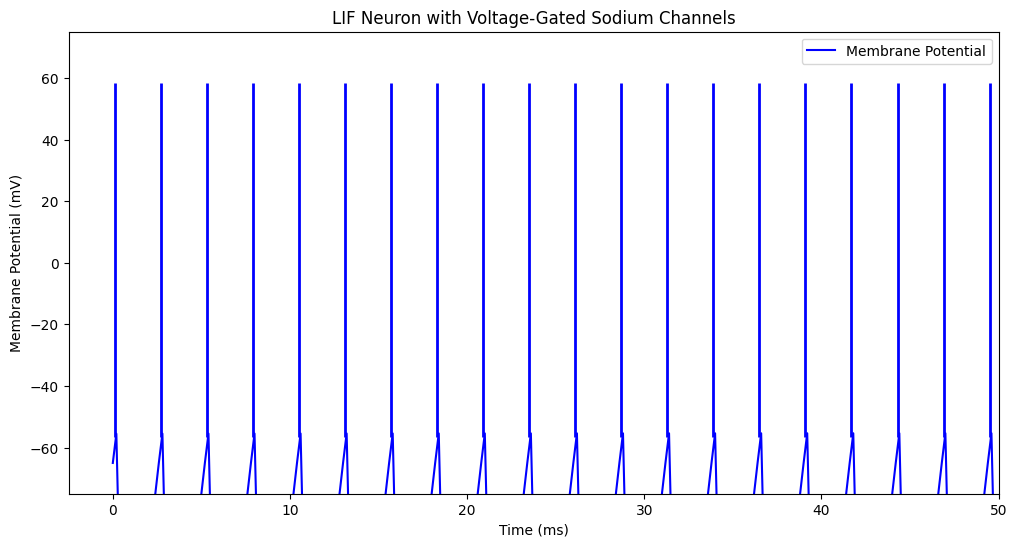

In [33]:
import numpy as np
import matplotlib.pyplot as plt

class LIFNeuronWithChannels:
    def __init__(self, tau_m=10, v_rest=-70, v_thresh=-55, tau_ref=2, v_reset=-80, v_spike=20, sodium_channels=True):
        self.tau_m = tau_m  # membrane time constant
        self.v_rest = v_rest  # resting membrane potential
        self.v_thresh = v_thresh  # threshold potential
        self.tau_ref = tau_ref  # refractory period
        self.v_reset = v_reset  # reset potential after a spike
        self.v_spike = v_spike  # spike potential
        self.sodium_channels = sodium_channels

        # Sodium channel parameters
        self.m = 0  # Sodium channel activation variable
        self.h = 1  # Sodium channel inactivation variable
        self.g_Na = 20  # Sodium conductance

        self.reset()

    def reset(self):
        self.v = self.v_rest
        self.refractory_time = 0
        self.m = 0
        self.h = 1

    def sodium_channel_dynamics(self, dt):
        alpha_m = 0.1 * (self.v + 40) / (1 - np.exp(-(self.v + 40) / 10))
        beta_m = 4 * np.exp(-(self.v + 65) / 18)

        alpha_h = 0.07 * np.exp(-(self.v + 65) / 20)
        beta_h = 1 / (1 + np.exp(-(self.v + 35) / 10))

        self.m += dt * (alpha_m * (1 - self.m) - beta_m * self.m)
        self.h += dt * (alpha_h * (1 - self.h) - beta_h * self.h)

    def update(self, dt, current):
        if self.refractory_time > 0:
            self.refractory_time -= dt
            self.v = self.v_reset
        else:
            dv = (-(self.v - self.v_rest) + current - self.g_Na * self.m**3 * self.h * (self.v - 50)) / self.tau_m * dt

            # Sodium channel dynamics
            if self.sodium_channels:
                self.sodium_channel_dynamics(dt)
                dv += self.g_Na * self.m**3 * self.h * (self.v - 50)

            self.v += dv

            if self.v >= self.v_thresh:
                self.v = self.v_reset
                self.refractory_time = self.tau_ref

def simulate_lif_neuron(neuron, currents, dt=0.1, duration=100):
    num_steps = int(duration / dt)

    voltages = []
    spike_times = []

    for i in range(num_steps):
        current = currents[i] if i < len(currents) else 0
        neuron.update(dt, current)
        voltages.append(neuron.v)

        if neuron.v >= neuron.v_thresh-1:
            spike_times.append(i * dt)

    time = np.arange(0, duration, dt)
    return time, voltages, spike_times

# Example usage:
currents = np.ones(1000) * 500  # 100 ms of input current
neuron_with_channels = LIFNeuronWithChannels(sodium_channels=True)
time, voltages, spike_times = simulate_lif_neuron(neuron_with_channels, currents)

# Plotting the results
plt.figure(figsize=(12, 6))

plt.plot(time, voltages, label='Membrane Potential', color='b')
plt.eventplot(np.array(spike_times)-0.1, color='b', linewidths=2, linelengths=115) # Draw the spikes

plt.title('LIF Neuron with Voltage-Gated Sodium Channels')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.ylim([-75, 75])
plt.xlim([-2.5,50])
plt.legend()

plt.show()



---

#### Question 3

ChatGPT added in the gating dynamics of voltage-gated sodium channels, but this did not have much of an effect on the actual output. It also included a reset potential which is a soft implementation of the effect of potassium channels causing repolarizaiton. One big issue we had was that the code would not actual reach threshold. This may have been a result of the added sodium dynamics. After trying different numbers for the dynamics like from this source [https://neuronaldynamics.epfl.ch/online/Ch2.S2.html](https://neuronaldynamics.epfl.ch/online/Ch2.S2.html). The different numbers did slightly change what we saw, but still the potential would not reach threshold, so we ultimately just made the spiking condition slightly easier to fire. Furthermore, we did not see some of the changes we expected like an actual action potential, we still had to use point spikes. So perhaps that is just built in to the Leaky Integrate and Fire model. Overall the new code is only marginally better in that it gives more parameters and defines a "reset" potential corresponding to potassium's equilibrium potential.


---

#### Question 4

GitHub isn’t capable of having live edits with multiple people with what he have right now. We used two different methods to try to integrate our GitHub with Jupyter Labs (one of which involved downloading an extension and the other was using coding), but both of them did not work due to the extension needing another software (which was not able to be downloaded) and the code simply not working or running properly. This has made it pretty hard since one person is doing most of the typing in GitHub, and no one else is really able to help with the typing.


---

#### Question 5

We predict that we will have to incorporate hidden layers with added complexity whereas the LIF model is purely analytical. Backpropagation requires training, which involves incorporating weights across the different layers, which will be more complex than the simple LIF model which simulates in a very straightforward manner. Because we anticipate a greater complexity of our model using a NN over just LIF, we expect that the NN can encode more information than the LIF neurons can.

An alternative view to just looking at the complexity of a neural network model versus Leaky Integrate and Fire from a coding perspective is that NNs are so prevalent in modern computing that it would actually be very easy to code. ChatGPT has been likely asked to code a neural network a thousand more times than something field-specific like a LIF model, and so at least for the basic framework of the code it may be easier for it. Since NNs also take care of some of the more analytical modelling features used in LIF, it could also require less steps. If we are not coding it from scratch, then I could also imagine it might take only a few lines using something like scikit.